In [1]:
import torch
import pytorch_lightning as pl

device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)

from hydra.experimental import initialize, compose

import numpy as np
import time 
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(184)
np.random.seed(143)

print(torch.__version__)
print(device)

1.7.1
cuda:6


In [2]:
from bliss import sleep
from bliss.datasets import simulated
from bliss.models import decoder

In [3]:
import sys
sys.path.append('../starnet_utils/')
import m2_data
import plotting
import starnet_metrics
import daophot_utils
import utils

In [4]:
import psf_optimization_utils as optim_utils

In [5]:
%matplotlib inline

# load data

In [6]:
from astropy.io import fits
hdul = fits.open('./data/decaps_l0_b0_hdu08_i')

image = torch.Tensor(hdul[1].data).unsqueeze(0).unsqueeze(0)

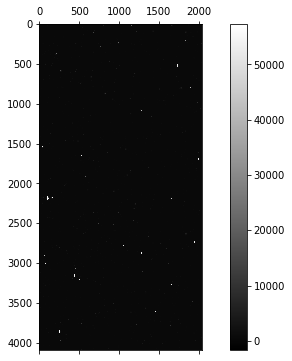

In [7]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))

im = plotting.plot_image(ax, image[0, 0])

f.colorbar(im, ax = ax)

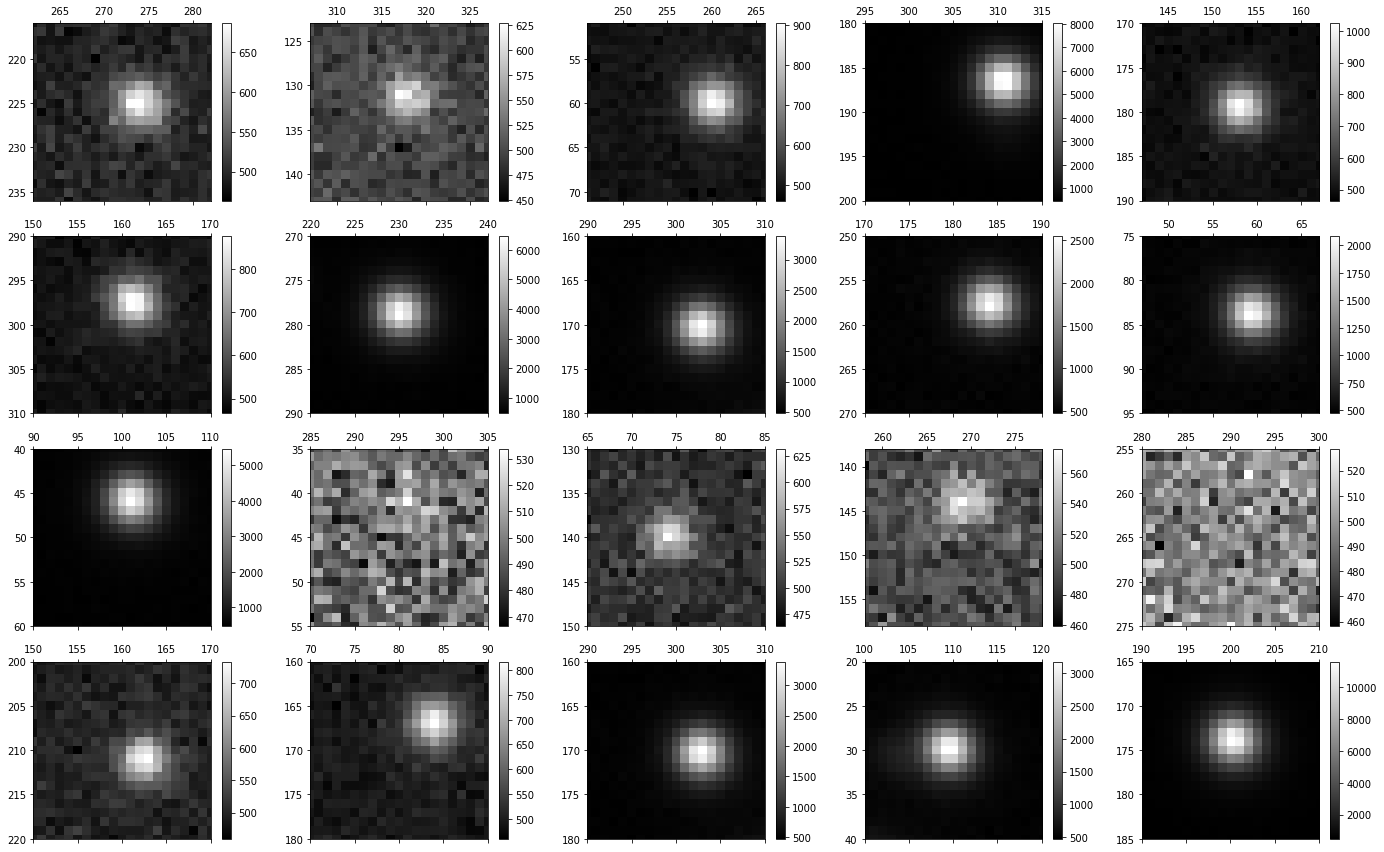

In [10]:
f, axarr = plt.subplots(4, 5, figsize=(24, 15))

subimage_slen = 20
# x0_vec = np.arange(x0, x0 + slen, subimage_slen)
# x1_vec = np.arange(x1, x1 + slen, subimage_slen)

x0_vec = np.array([216, 123, 51, 180, 170, 290, 270, 160, 250, 75, 
                   40, 35, 130, 138, 255, 200, 160, 160, 20, 165]) 
x1_vec = np.array([252, 297, 236, 285, 132, 140, 210, 280, 160,
                   37, 80, 275, 55, 248, 270, 140, 60, 280, 90, 180]) + 10

# x0_vec = [216, 123, 51, 170, 290, 35, 130, 138, 200, 160, 32, 54, 40, 20]
# x1_vec = [252, 297, 236, 132, 140, 275, 55, 248, 140, 60, 275, 157, 50, 195]

# x0_vec = [32]
# x1_vec = [275]

# x0_vec = [165]
# x1_vec = [180]


for i in range(len(x0_vec)): 
    _x0 = x0_vec[i]
    _x1 = x1_vec[i]
    
    ax = axarr[i // 5,  i % 5]
    
        
    im = plotting.plot_image(ax, 
                             image[0, 0], 
                             _x0, 
                             _x1,
                             subimage_slen,
                             subimage_slen)
    
    f.colorbar(im, ax = ax)

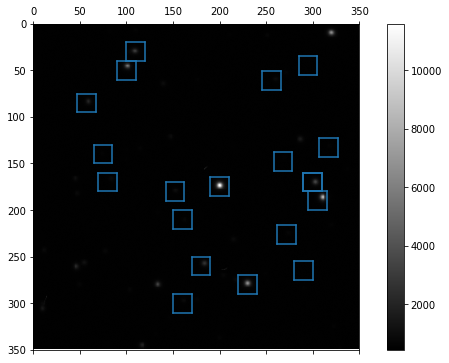

In [11]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))

tmp = image[0, 0, 0:350, 0:350]
im = plotting.plot_image(ax, tmp)

f.colorbar(im, ax = ax)

for i in range(len(x0_vec)): 
    _x0 = x0_vec[i]
    _x1 = x1_vec[i]
    
    ax.axvline(_x1, 
               ymin = (tmp.shape[1] - _x0) / tmp.shape[1], 
               ymax = (tmp.shape[1] - _x0 - subimage_slen) / tmp.shape[1])
    ax.axvline(_x1 + subimage_slen, 
               ymin = (tmp.shape[1] - _x0) / tmp.shape[1], 
               ymax = (tmp.shape[1] - _x0 - subimage_slen) / tmp.shape[1])

    ax.axhline(_x0, 
               xmin = _x1 / tmp.shape[0], 
               xmax = (_x1 + subimage_slen) / tmp.shape[1])
    ax.axhline(_x0 + subimage_slen, 
               xmin = _x1 / tmp.shape[0], 
               xmax = (_x1 + subimage_slen) / tmp.shape[1])

In [12]:
psf_test_images = torch.zeros(len(x0_vec), 
                              image.shape[1],
                              subimage_slen, 
                              subimage_slen)

for i in range(len(x0_vec)): 
    _x0 = x0_vec[i]
    _x1 = x1_vec[i]
    
    psf_test_images[i] = image[0, :, _x0:(_x0+subimage_slen), _x1:(_x1+subimage_slen)]

In [13]:
# f, axarr = plt.subplots(2, 5, figsize=(24, 8))

# for i in range(psf_test_images.shape[0]): 

#     ax = axarr[i // 5,  i % 5]
    
#     im = plotting.plot_image(ax, psf_test_images[i, 0])

In [14]:
tile_slen = 20
n_bands = 1
psf_slen = 51
# psf_params_file = './psf/zband_psf_gauss.npy'
psf_params_file = './psf/iband_psf_init.npy'
                    
tiler = decoder.Tiler(tile_slen, tile_slen)

star_decoder = decoder.StarTileDecoder(tiler, 
                                       n_bands = n_bands, 
                                       psf_slen = psf_slen, 
                                       psf_params_file = psf_params_file)


In [15]:
catalog_params = optim_utils.CatalogParams(n_images=psf_test_images.shape[0])

In [16]:
for p in star_decoder.parameters(): 
    print(p)

Parameter containing:
tensor([[ 1.3156,  2.0087,  0.0000,  0.0000, -0.6931, -0.6931]],
       dtype=torch.float64, requires_grad=True)


In [17]:
old_loss = 1e16
tol = 1e-5

for i in range(1000): 
    print('#### optimizing catalog')
    _ = optim_utils.run_lbfgs(psf_test_images, 
                              catalog_params, 
                              star_decoder, 
                              catalog_params.parameters(), 
                              lr = 1e-2,
                              detach_psf = True)
    
    print('#### optimizing psf')
    loss = optim_utils.run_lbfgs(psf_test_images, 
                                 catalog_params, 
                                 star_decoder, 
                                 star_decoder.parameters(), 
                                 detach_psf = False)
    
    diff = (loss - old_loss).abs()
    if diff < tol: 
        break
    
    old_loss = loss
    
print('done')

#### optimizing catalog
tensor(291.9976, grad_fn=<NegBackward>)
tensor(176.5284, grad_fn=<NegBackward>)
tensor(152.4755, grad_fn=<NegBackward>)
tensor(46.1022, grad_fn=<NegBackward>)
tensor(22.7158, grad_fn=<NegBackward>)
tensor(11.6535, grad_fn=<NegBackward>)
tensor(8.8888, grad_fn=<NegBackward>)
tensor(8.8704, grad_fn=<NegBackward>)
tensor(8.3985, grad_fn=<NegBackward>)
tensor(8.2662, grad_fn=<NegBackward>)
#### optimizing psf
tensor(7.7876, grad_fn=<NegBackward>)
tensor(5.7101, grad_fn=<NegBackward>)
tensor(5.7101, grad_fn=<NegBackward>)
tensor(5.7101, grad_fn=<NegBackward>)
#### optimizing catalog
tensor(5.7101, grad_fn=<NegBackward>)
tensor(5.2335, grad_fn=<NegBackward>)
tensor(5.0950, grad_fn=<NegBackward>)
tensor(5.0632, grad_fn=<NegBackward>)
tensor(5.0505, grad_fn=<NegBackward>)
tensor(5.0369, grad_fn=<NegBackward>)
tensor(5.0362, grad_fn=<NegBackward>)
tensor(5.0357, grad_fn=<NegBackward>)
tensor(5.0332, grad_fn=<NegBackward>)
tensor(5.0311, grad_fn=<NegBackward>)
#### optimi

tensor(4.4522, grad_fn=<NegBackward>)
tensor(4.4522, grad_fn=<NegBackward>)
tensor(4.4522, grad_fn=<NegBackward>)
tensor(4.4522, grad_fn=<NegBackward>)
tensor(4.4522, grad_fn=<NegBackward>)
tensor(4.4522, grad_fn=<NegBackward>)
tensor(4.4522, grad_fn=<NegBackward>)
tensor(4.4522, grad_fn=<NegBackward>)
#### optimizing psf
tensor(4.4522, grad_fn=<NegBackward>)
tensor(4.4521, grad_fn=<NegBackward>)
tensor(4.4521, grad_fn=<NegBackward>)
#### optimizing catalog
tensor(4.4521, grad_fn=<NegBackward>)
tensor(4.4521, grad_fn=<NegBackward>)
tensor(4.4521, grad_fn=<NegBackward>)
#### optimizing psf
tensor(4.4521, grad_fn=<NegBackward>)
tensor(4.4521, grad_fn=<NegBackward>)
tensor(4.4521, grad_fn=<NegBackward>)
#### optimizing catalog
tensor(4.4521, grad_fn=<NegBackward>)
tensor(4.4521, grad_fn=<NegBackward>)
tensor(4.4521, grad_fn=<NegBackward>)
tensor(4.4521, grad_fn=<NegBackward>)
tensor(4.4520, grad_fn=<NegBackward>)
tensor(4.4520, grad_fn=<NegBackward>)
#### optimizing psf
tensor(4.4520, gra

In [18]:
for p in star_decoder.parameters(): 
    print(p)

Parameter containing:
tensor([[ 1.8605,  0.9177,  1.9723,  1.4609,  1.2540, -0.6404]],
       dtype=torch.float64, requires_grad=True)


In [19]:
# this is the estimated sky background
catalog_params()[2]

tensor([495.5137], grad_fn=<ExpBackward>)

In [20]:
est_locs = catalog_params()[0].squeeze().cpu().detach().numpy()

In [21]:
recon_mean = optim_utils.get_loss(psf_test_images,
                                  catalog_params,
                                  star_decoder)[1].detach()

In [22]:
est_locs

array([[0.47957757, 0.6283659 ],
       [0.4366366 , 0.5732041 ],
       [0.46849683, 0.73960626],
       [0.35324714, 0.80531603],
       [0.49555305, 0.58022845],
       [0.40038574, 0.592563  ],
       [0.45831198, 0.53360707],
       [0.54125917, 0.66967684],
       [0.40917775, 0.72892326],
       [0.46481672, 0.6456726 ],
       [0.3171327 , 0.5818179 ],
       [0.38848814, 0.56716526],
       [0.51583517, 0.49119946],
       [0.32541704, 0.5822775 ],
       [0.4928726 , 0.50290996],
       [0.5777658 , 0.65018797],
       [0.369957  , 0.7233164 ],
       [0.5412588 , 0.6696764 ],
       [0.5191446 , 0.4924995 ],
       [0.46873993, 0.5391958 ]], dtype=float32)

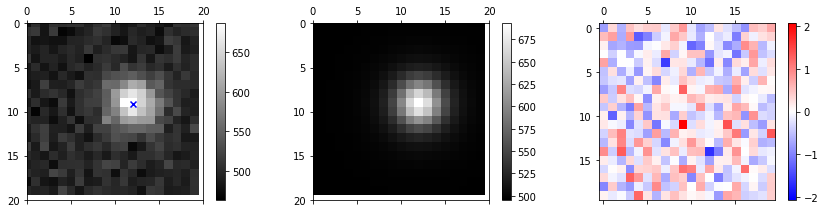

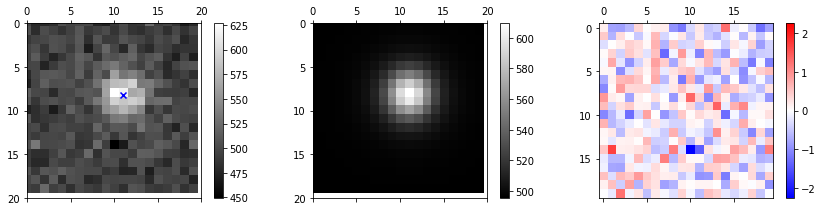

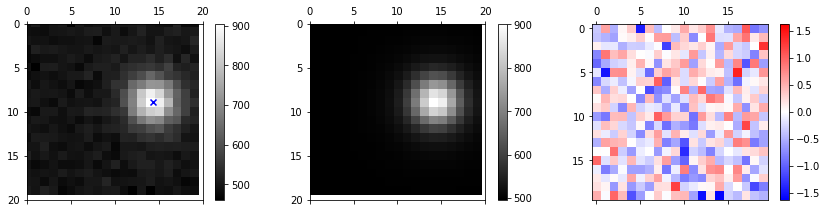

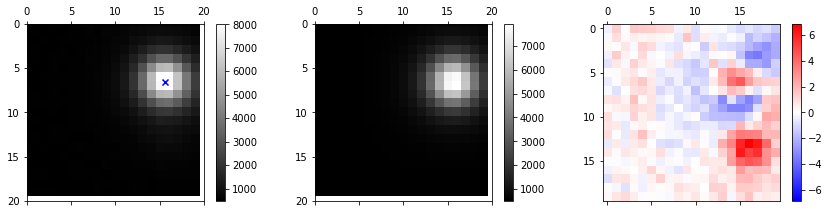

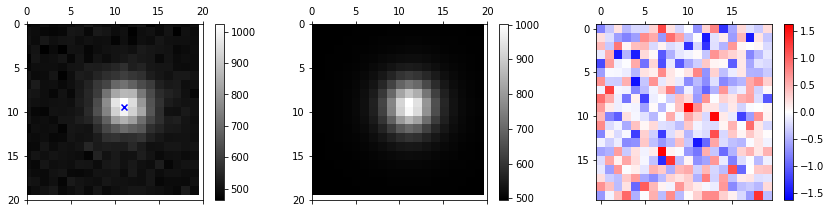

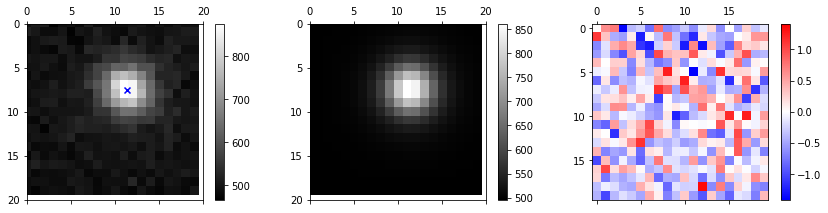

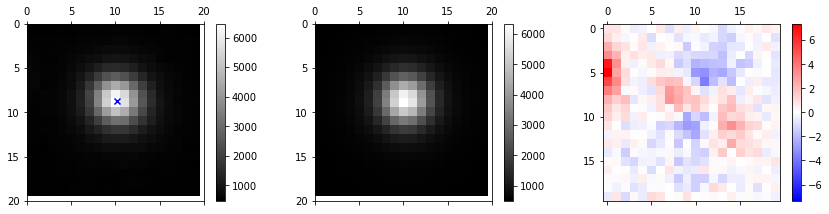

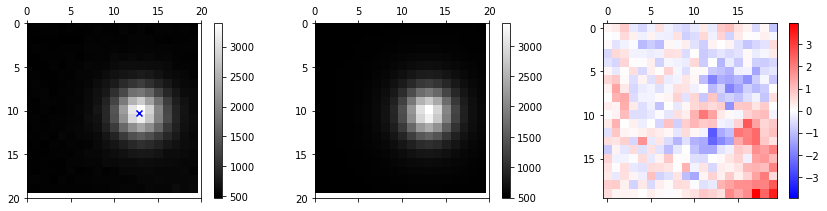

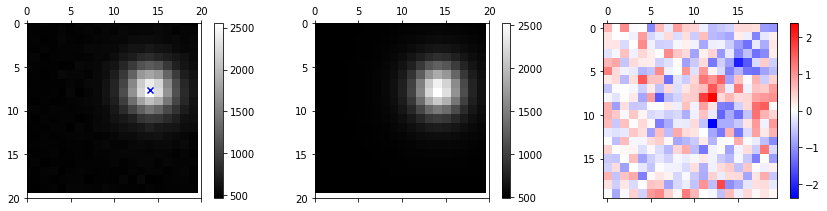

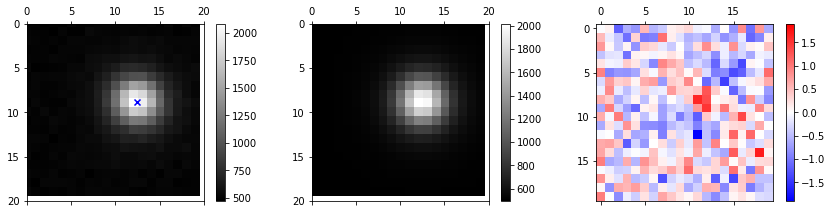

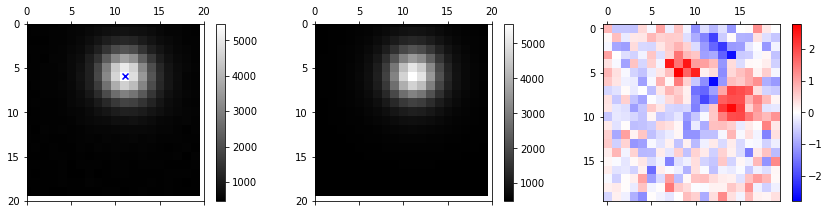

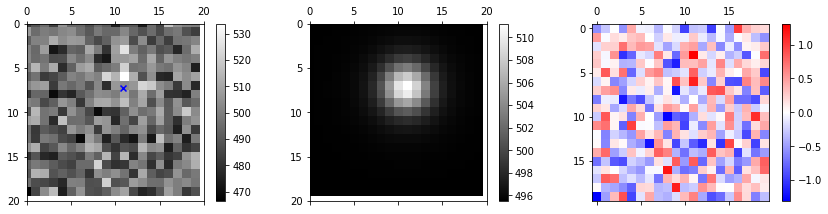

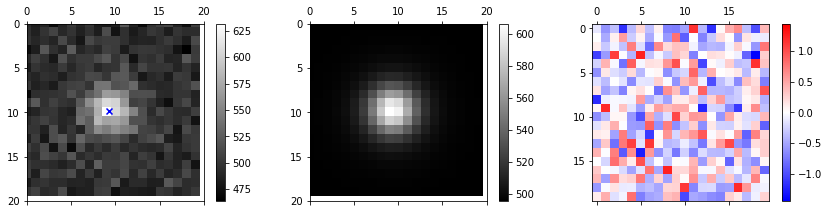

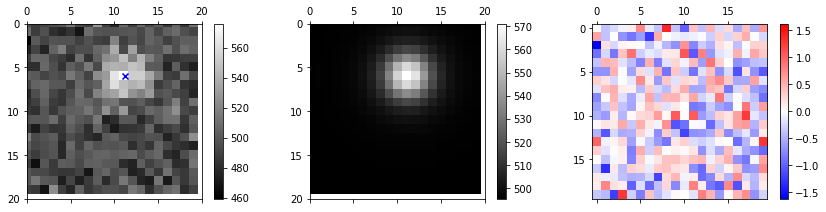

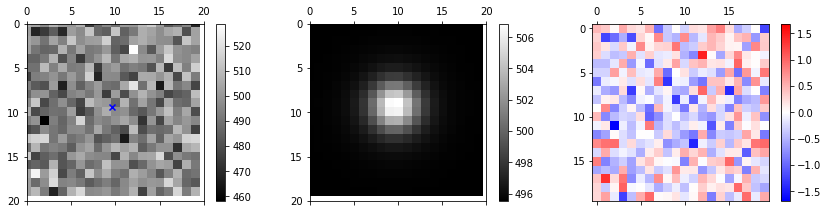

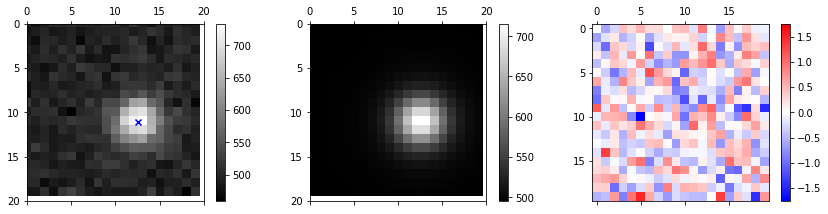

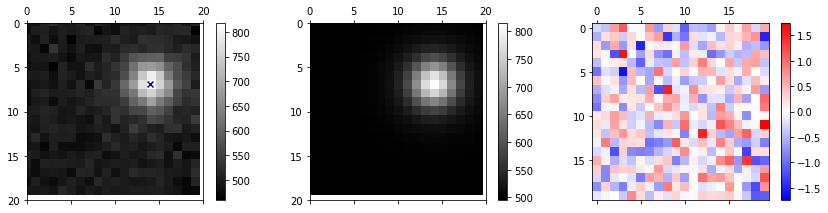

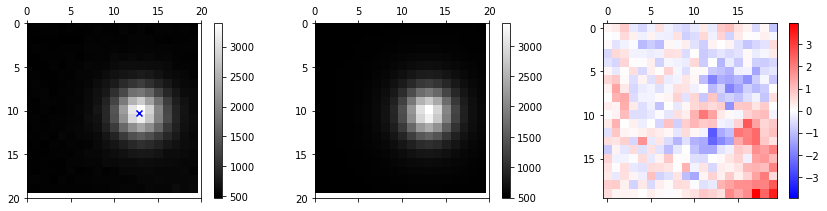

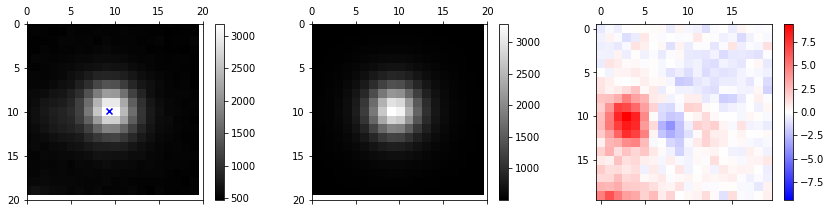

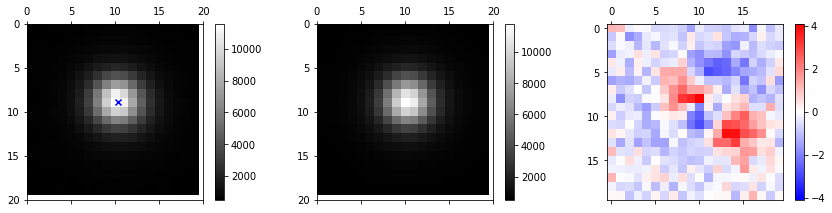

In [23]:
for i in range(psf_test_images.shape[0]): 

    f, axarr = plt.subplots(1, 3, figsize=(12, 3))
    
    im0 = plotting.plot_image(axarr[0], psf_test_images[i, 0])
    f.colorbar(im0, ax = axarr[0])
    
    
    im1 = plotting.plot_image(axarr[1], recon_mean[i, 0])
    f.colorbar(im1, ax = axarr[1])
    
    diff = (psf_test_images[i, 0] - recon_mean[i, 0]) / torch.sqrt(recon_mean[i, 0])
    vmax = torch.max(torch.abs(diff))
    im3 = axarr[2].matshow(diff, 
                           cmap = plt.get_cmap('bwr'), 
                           vmax = vmax, vmin = -vmax)
    f.colorbar(im3, ax = axarr[2])
    
    plotting.plot_locations(est_locs[i:(i+1), :] * subimage_slen,
                            axarr[0], 
                            marker = 'x')
    
    f.tight_layout()

In [24]:
np.save('./psf/iband_psf_fitted.npy', 
        star_decoder.params.detach().numpy())

In [25]:
np.load('./psf/iband_psf_fitted.npy')

array([[ 1.86049134,  0.91766824,  1.97225989,  1.4608617 ,  1.25396037,
        -0.64035019]])

In [26]:
subimage_locs = np.array([x0_vec, x1_vec]).transpose()

In [27]:
np.save('./est_locs_i.npy', 
        est_locs * subimage_slen + subimage_locs)

In [29]:
i_psf = np.load('./psf/iband_psf_fitted.npy')
z_psf = np.load('./psf/zband_psf_fitted.npy')

In [30]:
np.save('./psf/ziband_psf_fitted.npy', 
        np.vstack([z_psf, i_psf]))

In [3]:
# psf_params_file = './psf/zband_psf_gauss.npy'
                    
# tiler = decoder.Tiler(tile_slen, tile_slen)

# star_decoder_gauss = decoder.StarTileDecoder(tiler, 
#                                        n_bands = n_bands, 
#                                        psf_slen = psf_slen, 
#                                        psf_params_file = psf_params_file)